# 第10章: 機械翻訳
本章では，日本語と英語の翻訳コーパスである京都フリー翻訳タスク (KFTT)を用い，ニューラル機械翻訳モデルを構築する．ニューラル機械翻訳モデルの構築には，fairseq，Hugging Face Transformers，OpenNMT-pyなどの既存のツールを活用せよ．

## 90. データの準備
機械翻訳のデータセットをダウンロードせよ．訓練データ，開発データ，評価データを整形し，必要に応じてトークン化などの前処理を行うこと．ただし，この段階ではトークンの単位として形態素（日本語）および単語（英語）を採用せよ．

https://qiita.com/y-aramak/items/8dc8098698cb0f92116a zxvfについて

In [ ]:
!tar zxvf ./data/kftt-data-1.0.tar.gz

x kftt-data-1.0/
x kftt-data-1.0/data/
x kftt-data-1.0/data/orig/
x kftt-data-1.0/data/orig/kyoto-tune.en
x kftt-data-1.0/data/orig/kyoto-dev.ja
x kftt-data-1.0/data/orig/kyoto-dev.en
x kftt-data-1.0/data/orig/kyoto-train.en
x kftt-data-1.0/data/orig/kyoto-tune.ja
x kftt-data-1.0/data/orig/kyoto-train.ja
x kftt-data-1.0/data/orig/kyoto-test.ja
x kftt-data-1.0/data/orig/kyoto-test.en
x kftt-data-1.0/data/tok/
x kftt-data-1.0/data/tok/kyoto-tune.en
x kftt-data-1.0/data/tok/kyoto-dev.ja
x kftt-data-1.0/data/tok/kyoto-train.cln.en
x kftt-data-1.0/data/tok/kyoto-dev.en
x kftt-data-1.0/data/tok/kyoto-train.en
x kftt-data-1.0/data/tok/kyoto-tune.ja
x kftt-data-1.0/data/tok/kyoto-train.cln.ja
x kftt-data-1.0/data/tok/kyoto-train.ja
x kftt-data-1.0/data/tok/kyoto-test.ja
x kftt-data-1.0/data/tok/kyoto-test.en
x kftt-data-1.0/README.txt


In [ ]:
!cat kftt-data-1.0/data/orig/kyoto-train.ja | sed 's/\s+/ /g' | ginzame > train.ginza.ja
!cat kftt-data-1.0/data/orig/kyoto-dev.ja | sed 's/\s+/ /g' | ginzame > dev.ginza.ja
!cat kftt-data-1.0/data/orig/kyoto-test.ja | sed 's/\s+/ /g' | ginzame > test.ginza.ja

In [ ]:

for src, dst in [
    ('train.ginza.ja', 'train.spacy.ja'),
    ('dev.ginza.ja', 'dev.spacy.ja'),
    ('test.ginza.ja', 'test.spacy.ja'),
]:
    with open(src) as f:
        lst = []
        tmp = []
        for x in f:
            x = x.strip()
            if x == 'EOS':
                lst.append(' '.join(tmp))
                tmp = []
            elif x != '':
                tmp.append(x.split('\t')[0])
    with open(dst, 'w') as f:
        for line in lst:
            print(line, file=f)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
import re
train_data = "kftt-data-1.0/data/orig/kyoto-train.en"
dev_data = "kftt-data-1.0/data/orig/kyoto-dev.en"
test_data = "kftt-data-1.0/data/orig/kyoto-test.en"
with open(train_data, encoding="utf-8") as f, open("train.spacy.en", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = nlp.make_doc(sen)
        sen = ' '.join([doc.text for doc in sen])
        print(sen, file=g)


In [ ]:
with open(dev_data, encoding="utf-8") as f, open("dev.spacy.en", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = nlp.make_doc(sen)
        sen = ' '.join([doc.text for doc in sen])
        print(sen, file=g)

In [ ]:
with open(test_data, encoding="utf-8") as f, open("test.spacy.en", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = nlp.make_doc(sen)
        sen = ' '.join([doc.text for doc in sen])
        print(sen, file=g)

In [ ]:
!head train.spacy.en

Known as Sesshu ( 1420 - 1506 ) , he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century , and was called a master painter .
He revolutionized the Japanese ink painting .
He was given the posthumous name " Toyo " or " Sesshu ( 拙宗 ) . "
Born in Bicchu Province , he moved to Suo Province after entering SShokoku - ji Temple in Kyoto .
Later he accompanied a mission to Ming Dynasty China and learned Chinese ink painting .
His works were many , including not only Chinese - style landscape paintings , but also portraits and pictures of flowers and birds .
His bold compositions and strong brush strokes constituted an extremely distinctive style .
6 of his extant works are designated national treasures . Indeed , he is considered to be extraordinary among Japanese painters .
For this reason , there are a great many artworks that are attributed to him , such as folding screens with pictures of flowers and that birds are painted on them .
There a

## 91. 機械翻訳モデルの訓練
90で準備したデータを用いて，ニューラル機械翻訳のモデルを学習せよ（ニューラルネットワークのモデルはTransformerやLSTMなど適当に選んでよい）．

In [ ]:
!fairseq-preprocess -s ja -t en \
   --trainpref /content/drive/MyDrive/NLP100Knock/train.spacy \
   --validpref /content/drive/MyDrive/NLP100Knock/dev.spacy \
   --testpref /content/drive/MyDrive/NLP100Knock/test.spacy \
   --destdir /content/drive/MyDrive/NLP100Knock/ja_en \
   --thresholdsrc 5 \
   --thresholdtgt 5 \
   --task translation 
# pref で参照元を指定
# destdir で保存先を指定
# threshold で閾値以下の単語をunkにマップ
# task defalut translation

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 3000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save91 > 91train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

## 92. 機械翻訳モデルの適用
91で学習したニューラル機械翻訳モデルを用い，与えられた（任意の）日本語の文を英語に翻訳するプログラムを実装せよ．

In [ ]:
!pip install ja-ginza

In [ ]:
import spacy
nlp = spacy.load('ja_ginza')
from fairseq.models.transformer import TransformerModel

2022-06-29 05:47:00 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX


In [ ]:
DICT_PATH = "/content/drive/MyDrive/NLP100Knock/ja_en"
MODEL_PATH = '/content/drive/MyDrive/NLP100Knock/save91'
MODEL_CHECKPOINT = 'checkpoint_best.pt'

In [ ]:
model = TransformerModel.from_pretrained(MODEL_PATH, MODEL_CHECKPOINT, DICT_PATH)

In [ ]:
TEXT = "英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)

英語 に 翻訳 し ます 。


In [ ]:
model.translate(TEXT)

'It is translated into English .'

閾値を2->5に変えたら　元 "He translated into English"みたいなやつからまともな翻訳になった

In [ ]:
TEXT = "日本語を英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)

日本語 を 英語 に 翻訳 し ます 。


In [ ]:
model.translate(TEXT)

'He translated English .'

In [ ]:
# trainデータを翻訳してみる
model.translate("雪舟 （ せっ しゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。")

'Sesshu ( 1420 - 1506 ) was a priest and Zen monk who was active in the late Muromachi period and was praised as a master .'

## 93. BLEUスコアの計測
91で学習したニューラル機械翻訳モデルの品質を調べるため，評価データにおけるBLEUスコアを測定せよ．

In [ ]:
!fairseq-generate /content/drive/MyDrive/NLP100Knock/ja_en \
  --path /content/drive/MyDrive/NLP100Knock/save91/checkpoint_best.pt \
  --task translation \
  --gen-subset test  > /content/drive/MyDrive/NLP100Knock/bleuresult.txt

# --beam でビームサイズ指定 default 5

In [ ]:
!tail -n 1  /content/drive/MyDrive/NLP100Knock/bleuresult.txt

Generate test with beam=5: BLEU4 = 22.26, 56.1/29.3/17.7/11.2 (BP=0.932, ratio=0.934, syslen=25819, reflen=27636)


## 94. ビーム探索
91で学習したニューラル機械翻訳モデルで翻訳文をデコードする際に，ビーム探索を導入せよ．ビーム幅を1から100くらいまで適当に変化させながら，開発セット上のBLEUスコアの変化をプロットせよ．

In [ ]:
%%bash
for k in {1..22} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save91/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/bleuresult_${k}.txt
done

ログが長すぎたので消した 22までcudaのメモリエラーがかからなかったので22まで

In [ ]:
beam_num = [i+1 for i in range(22)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

In [ ]:
BLEU4_score

[20.94,
 21.86,
 21.95,
 21.91,
 22.26,
 22.31,
 22.34,
 22.32,
 22.35,
 22.26,
 22.31,
 22.3,
 22.37,
 22.32,
 22.31,
 22.25,
 22.25,
 22.36,
 22.3,
 22.27,
 22.3,
 22.34]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

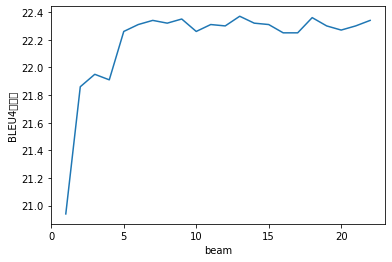

In [ ]:
import matplotlib.pyplot as plt
plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

## 95. サブワード化
トークンの単位を単語や形態素からサブワードに変更し，91-94の実験を再度実施せよ．

前処理からやり直し
fairseq train のbpeはなんなんだろう

In [ ]:
# これではないらしい
!fairseq-train /content/drive/MyDrive/NLP100Knock/ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 3000 \
  --bpe byte_bpe\
  --save-dir /content/drive/MyDrive/NLP100Knock/save95 > 95train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

日本語はsentencepiece 英語はsubword-nmtを用いる

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

# 学習の実行
spm.SentencePieceTrainer.Train(
   '--input=/content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-train.ja --model_prefix=/content/drive/MyDrive/NLP100Knock/sentencepiece --vocab_size=8000 --character_coverage=0.9995'
)

In [ ]:
import sentencepiece as spm

In [ ]:
# モデルの作成
sp = spm.SentencePieceProcessor()
sp.Load("/content/drive/MyDrive/NLP100Knock/sentencepiece.model")

True

In [ ]:
import re
train_data = "/content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-train.ja"
dev_data = "/content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-dev.ja"
test_data = "/content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-test.ja"
with open(train_data, encoding="utf-8") as f, open("/content/drive/MyDrive/NLP100Knock/train.subword.ja", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = sp.EncodeAsPieces(sen)
        sen = ' '.join([doc for doc in sen])
        print(sen, file=g)

In [ ]:
with open(dev_data, encoding="utf-8") as f, open("/content/drive/MyDrive/NLP100Knock/dev.subword.ja", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = sp.EncodeAsPieces(sen)
        sen = ' '.join([doc for doc in sen])
        print(sen, file=g)

In [ ]:
with open(test_data, encoding="utf-8") as f, open("/content/drive/MyDrive/NLP100Knock/test.subword.ja", "w", encoding="utf-8") as g:
    for sen in f:
        sen = sen.strip() # 改行の削除
        sen = re.sub(r'\s+', ' ', sen)
        sen = sp.EncodeAsPieces(sen)
        sen = ' '.join([doc for doc in sen])
        print(sen, file=g)

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/train.subword.ja

▁ 雪 舟 ( せ っ しゅう 、 14 20 年 ( 応永 27 年 )- 1 50 6 年 ( 永正 3 年 ) ) は 号 で 、 15 世紀後半 室町時代 に 活躍した 水 墨 画家 ・ 禅 僧 で 、 画 聖 とも 称 え られる 。
▁日本の 水 墨 画 を 一 変 させた 。
▁ 諱 は 「 等 楊 ( とう よう ) 」 、 もしくは 「 拙 宗 ( せ っ しゅう ) 」 と 号 した 。
▁ 備 中国 に 生まれ 、 京都 ・ 相 国 寺 に入って から 周 防 国 に 移 る 。
▁その後 遣 明 使 に 随 行 して 中国 ( 明 ) に 渡 って 中国の 水 墨 画 を学んだ 。
▁ 作品 は 数多く 、 中国 風 の 山 水 画 だけでなく 人物 画 や 花 鳥 画 も よく した 。
▁大 胆 な 構 図 と 力 強い 筆 線 は 非常に 個 性 的な 画 風 を 作り 出 している 。
▁ 現存する 作品 のうち 6 点 が 国宝 に 指定 されており 、 日本の 画家 のなかで も 別 格 の 評価 を受け ている といえる 。
▁このため 、 花 鳥 図 屏風 などに 「 伝 雪 舟 筆 」 される 作品 は 大 変 多い 。
▁ 真 筆 である か 専門 家 の間で も 意見 の 分 かれる もの も 多 々 ある 。


In [ ]:
!pip install subword-nmt

In [ ]:
# 去年までのを見ると16000でやってるのが多い　→なんでだろう
!subword-nmt learn-bpe -s 16000 < /content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-train.en > /content/drive/MyDrive/NLP100Knock/kyoto_en.codes

100% 16000/16000 [01:07<00:00, 237.72it/s]


In [ ]:
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/kyoto_en.codes < /content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-train.en > /content/drive/MyDrive/NLP100Knock/train.subword.en
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/kyoto_en.codes < /content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-dev.en > /content/drive/MyDrive/NLP100Knock/dev.subword.en
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/kyoto_en.codes < /content/drive/MyDrive/NLP100Knock/kftt-data-1.0/data/orig/kyoto-test.en > /content/drive/MyDrive/NLP100Knock/test.subword.en

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/train.subword.en

K@@ n@@ own as Ses@@ shu (14@@ 20 - 150@@ 6@@ ), he was an ink painter and Zen monk active in the Muromachi period in the latter half of the 15th century, and was called a master pain@@ ter.
He revol@@ ut@@ ion@@ ized the Japanese ink paint@@ ing.
He was given the posthumous name "@@ Toyo@@ " or "S@@ es@@ shu (@@ 拙@@ 宗@@ )."
Born in Bicchu Province, he moved to Suo Province after entering S@@ Shokoku-ji Temple in Kyoto.
Later he accompanied a mission to Ming Dynasty China and learned Chinese ink paint@@ ing.
His works were man@@ y, including not only Chinese-style landscape paintings, but also portraits and pictures of flowers and bird@@ s.
His b@@ old compos@@ itions and strong brush st@@ rok@@ es const@@ ituted an extremely distinctive style.
6 of his ext@@ ant works are designated national treasu@@ res. In@@ de@@ ed, he is considered to be extraordinary among Japanese pain@@ ters.
For this reason, there are a great many art@@ works that are attributed to him, such as folding scre@@ 

In [ ]:
!fairseq-preprocess -s ja -t en \
   --trainpref /content/drive/MyDrive/NLP100Knock/train.subword \
   --validpref /content/drive/MyDrive/NLP100Knock/dev.subword \
   --testpref /content/drive/MyDrive/NLP100Knock/test.subword \
   --destdir /content/drive/MyDrive/NLP100Knock/subword_ja_en \
   --thresholdsrc 5 \
   --thresholdtgt 5 \
   --task translation 
# pref で参照元を指定
# destdir で保存先を指定
# threshold で閾値以下の単語をunkにマップ
# task defalut translation

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/subword_ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 3000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save95 > /content/drive/MyDrive/NLP100Knock/95train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

In [ ]:
DICT_PATH = "/content/drive/MyDrive/NLP100Knock/subword_ja_en"
MODEL_PATH = '/content/drive/MyDrive/NLP100Knock/save95'
MODEL_CHECKPOINT = 'checkpoint_best.pt'

In [ ]:
import spacy
nlp = spacy.load('ja_ginza')
from fairseq.models.transformer import TransformerModel
model = TransformerModel.from_pretrained(MODEL_PATH, MODEL_CHECKPOINT, DICT_PATH)

In [ ]:
TEXT = "英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)
model.translate(TEXT)

英語 に 翻訳 し ます 。


'He translated English into English@@ .'

In [ ]:
TEXT = "日本語を英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)
model.translate(TEXT)

日本語 を 英語 に 翻訳 し ます 。


'He translated English into English@@ .'

In [ ]:
# trainデータを翻訳してみる
model.translate("雪舟 （ せっ しゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。")

'He was a painter and painter who lived during the latter half of the 15th century and was active in the Muromachi period in the latter half of the 15th century.'

In [ ]:
%%bash
for k in {1..29} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/subword_ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save95/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/sub_bleuresult_${k}.txt
done

In [ ]:
beam_num = [i+1 for i in range(29)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/sub_bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

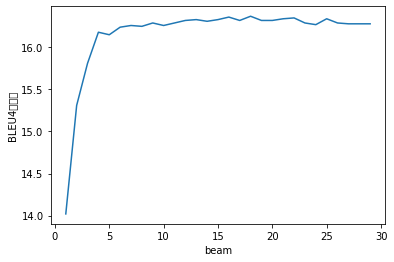

In [ ]:
import matplotlib.pyplot as plt
plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

結構スコア下がった

## 96. 学習過程の可視化
Tensorboardなどのツールを用い，ニューラル機械翻訳モデルが学習されていく過程を可視化せよ．可視化する項目としては，学習データにおける損失関数の値とBLEUスコア，開発データにおける損失関数の値とBLEUスコアなどを採用せよ．

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/subword_ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 2 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 3000 \
  --tensorboard-logdir /content/drive/MyDrive/NLP100Knock/96logs \
  --bpe sentencepiece \
  --save-dir /content/drive/MyDrive/NLP100Knock/save96 > /content/drive/MyDrive/NLP100Knock/96train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

In [ ]:
!pip install tensorboard tensorboardX

In [ ]:
!tensorboard --logdir=96logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)


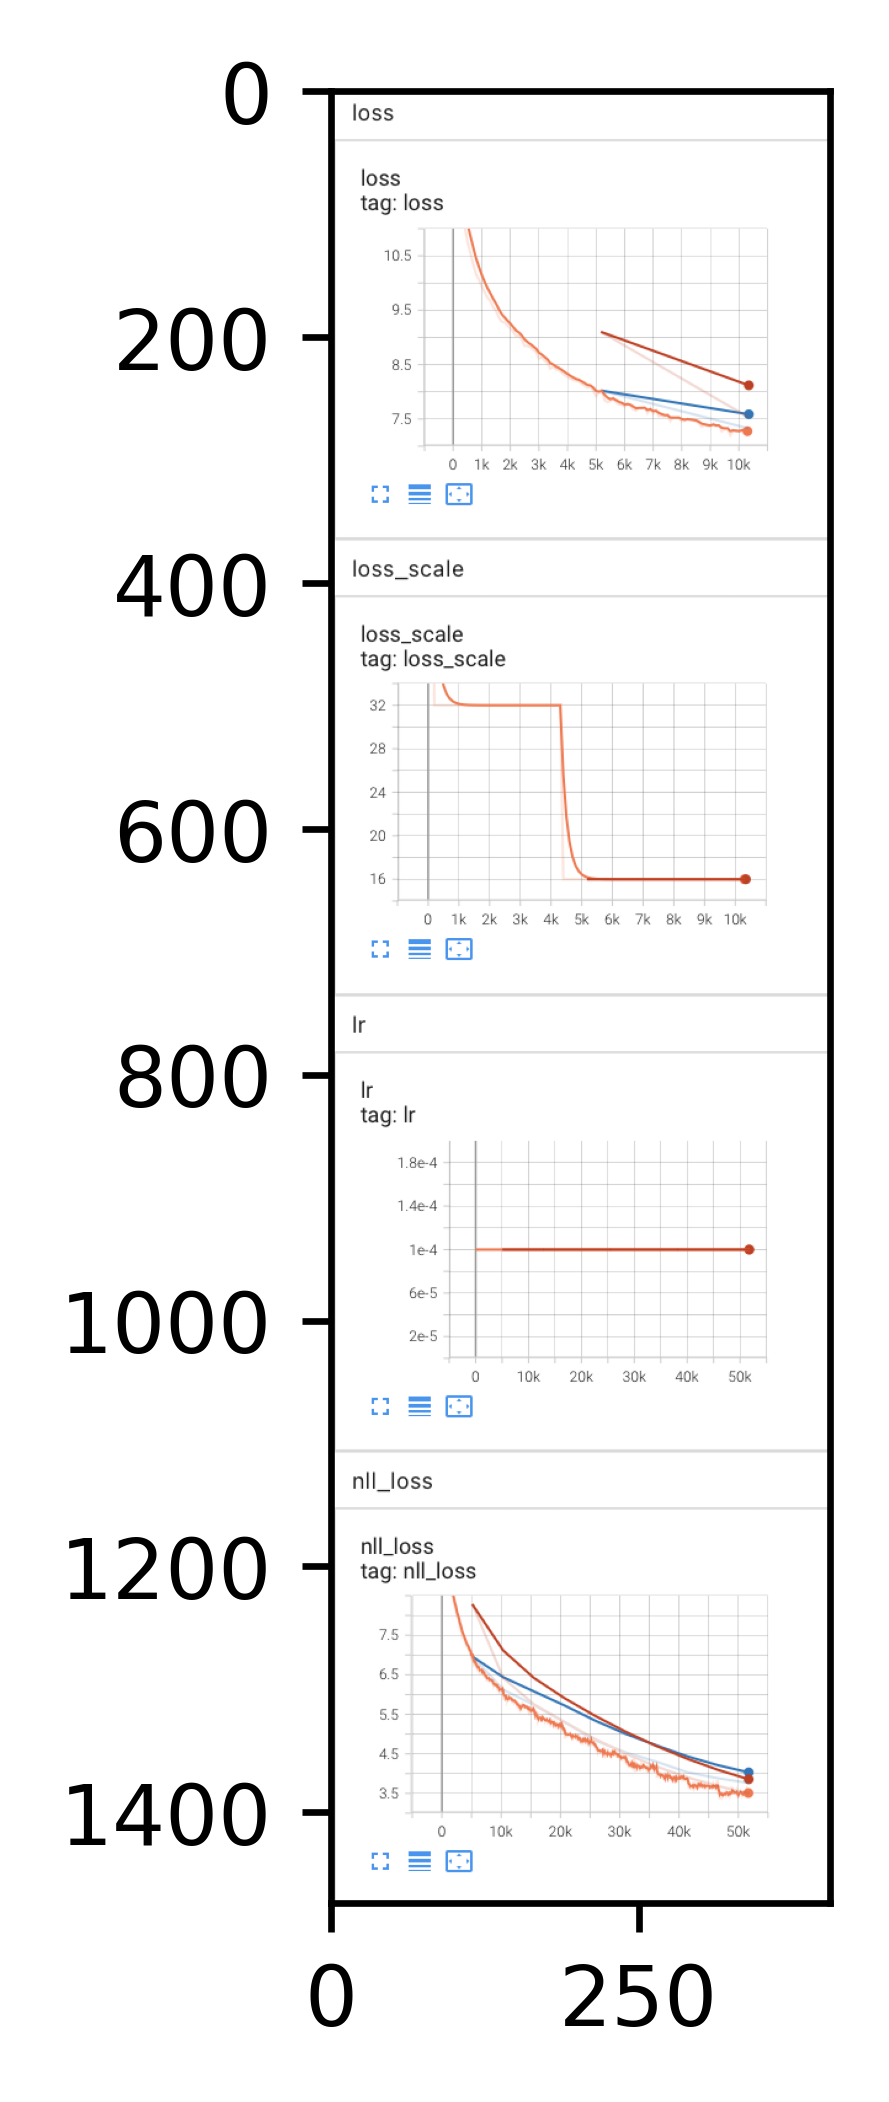

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/NLP100Knock/96log.png")
fig = plt.figure(dpi=600)
imgplot = plt.imshow(img)

## 97. ハイパー・パラメータの調整
ニューラルネットワークのモデルや，そのハイパーパラメータを変更しつつ，開発データにおけるBLEUスコアが最大となるモデルとハイパーパラメータを求めよ．

サブワード化したらBLEUスコアが落ちたからしないほうがいいのか？
とりあえずlrが学習中に変化させる設定とかoptimizerとかを変えてみる
アーキテクチャも変える？
時間かかるのであまりいじらない

In [ ]:
# lrのスケジュール設定、ドロップアウトをいじってみる
!fairseq-train /content/drive/MyDrive/NLP100Knock/ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 2000 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 3000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save97_var1 > /content/drive/MyDrive/NLP100Knock/97train_ver1.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu

In [ ]:
# dropout0.5
!fairseq-train /content/drive/MyDrive/NLP100Knock/ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 2000 --weight-decay 0.0001\
  --dropout 0.5 \
  --max-tokens 3000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save97_var2 > /content/drive/MyDrive/NLP100Knock/97train_ver2.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/ja_en \
  --task translation \
  --arch lstm \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 2000 --weight-decay 0.0001\
  --dropout 0.5 \
  --max-tokens 3000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save97_var3 > /content/drive/MyDrive/NLP100Knock/97train_ver3.log
# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu

In [ ]:
max_BLEU_arc = ""
max_BLEU = 0.0

In [ ]:
%%bash
for k in {1..20} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save97_var1/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/ver1/bleuresult_${k}.txt
done

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

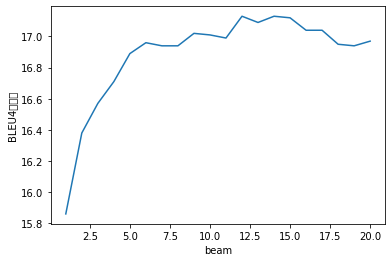

In [ ]:
beam_num = [i+1 for i in range(20)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/ver1/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

if max_BLEU < max(BLEU4_score):
    max_BLEU = max(BLEU4_score)
    max_BLEU_arc = "trans_drop0.2"


plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

In [ ]:
%%bash
for k in {1..20} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save97_var2/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/ver2/bleuresult_${k}.txt
done

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

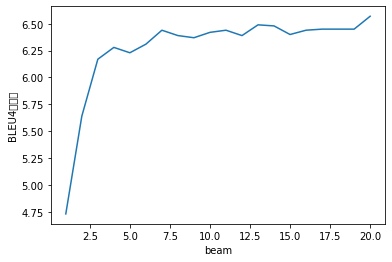

In [ ]:
beam_num = [i+1 for i in range(20)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/ver2/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

if max_BLEU < max(BLEU4_score):
    max_BLEU = max(BLEU4_score)
    max_BLEU_arc = "trans_drop0.5"

plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

dropoutさん？

In [ ]:
%%bash
for k in {1..20} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save97_var3/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/ver3/bleuresult_${k}.txt
done

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

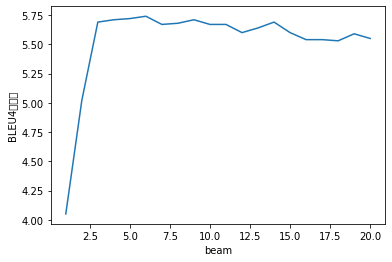

In [ ]:
beam_num = [i+1 for i in range(20)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/ver3/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

if max_BLEU < max(BLEU4_score):
    max_BLEU = max(BLEU4_score)
    max_BLEU_arc = "lstm_drop0.5"

plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

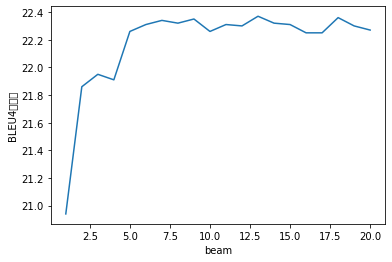

In [ ]:
beam_num = [i+1 for i in range(20)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

if max_BLEU < max(BLEU4_score):
    max_BLEU = max(BLEU4_score)
    max_BLEU_arc = "問題94"

plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

In [ ]:
print(max_BLEU, max_BLEU_arc)

22.37 問題94


何もしないほうがスコアが高いのなぜ・・・

## 98. ドメイン適応
Japanese-English Subtitle Corpus (JESC)やJParaCrawlなどの翻訳データを活用し，KFTTのテストデータの性能向上を試みよ．

JESCでpreprocessやったあとKFTTで再学習させるのかな？

In [ ]:
!tar zxvf /content/drive/MyDrive/NLP100Knock/data/split.tar.gz

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/split/dev

you are back, aren't you, harold?	あなたは戻ったのね ハロルド?
my opponent is shark.	俺の相手は シャークだ。
this is one thing in exchange for another.	引き換えだ ある事とある物の
yeah, i'm fine.	もういいよ ごちそうさま ううん
don't come to the office anymore. don't call me either.	もう会社には来ないでくれ 電話もするな
looks beautiful.	きれいだ。
get him out of here, because i will fucking kill him.	連れて行け 殺しそうだ わかったか?
you killed him!	殺したのか!
okay, then who?	わぁ~! いつも すみません。 いいのよ~。
it seems a former employee...	カンパニーの元社員が


In [ ]:
# 日本語と英語で分ける
for src, dst1, dst2 in [
    ("/content/drive/MyDrive/NLP100Knock/split/train","/content/drive/MyDrive/NLP100Knock/split/train_en", "/content/drive/MyDrive/NLP100Knock/split/train_ja"),
    ("/content/drive/MyDrive/NLP100Knock/split/dev", "/content/drive/MyDrive/NLP100Knock/split/dev_en", "/content/drive/MyDrive/NLP100Knock/split/dev_ja"),
    ("/content/drive/MyDrive/NLP100Knock/split/test", "/content/drive/MyDrive/NLP100Knock/split/test_en", "/content/drive/MyDrive/NLP100Knock/split/test_ja")
]:
    with open(src, "r", encoding="utf-8") as f, open(dst1, "w", encoding="utf-8") as g, open(dst2, "w", encoding="utf-8") as h:
        for sen in f:
            sen = sen.strip()
            en, ja = sen.split("\t")
            print(en, file=g)
            print(ja, file=h)

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/split/train_ja

スリバン人です
生徒がお互いの受精じゃなくて 植物の受粉に熱中してくれてるよ!
この雨の中 一晩中 墓地にいたい?
船はもう攻撃発起位置にある。
オリジナルの サムが居るんだぞ
でも ヤダから お仕事 辞めて!
悟空は 一人旅を続けて どんどん強くなった。
これより 緊急隊首会を行う。
言い換えれば 今ここにいる部屋の
一体どこに居るの?


サブワード化

In [ ]:
import sentencepiece as spm

# 学習の実行
spm.SentencePieceTrainer.Train(
   '--input=/content/drive/MyDrive/NLP100Knock/split/train_ja --model_prefix=/content/drive/MyDrive/NLP100Knock/sentencepiece98 --vocab_size=8000 --character_coverage=0.9995'
)

In [ ]:
# モデルの作成
sp = spm.SentencePieceProcessor()
sp.Load("/content/drive/MyDrive/NLP100Knock/sentencepiece98.model")

True

In [ ]:
import re
for src, dst in [
    ("/content/drive/MyDrive/NLP100Knock/split/train_ja", "/content/drive/MyDrive/NLP100Knock/98subword/train.ja"),
    ("/content/drive/MyDrive/NLP100Knock/split/dev_ja", "/content/drive/MyDrive/NLP100Knock/98subword/dev.ja"),
    ("/content/drive/MyDrive/NLP100Knock/split/test_ja", "/content/drive/MyDrive/NLP100Knock/98subword/test.ja"),
]:
    with open(src, encoding="utf-8") as f, open(dst, "w", encoding="utf-8") as g:
        for sen in f:
            sen = sen.strip() # 改行の削除
            sen = re.sub(r'\s+', ' ', sen)
            sen = sp.EncodeAsPieces(sen)
            sen = ' '.join([doc for doc in sen])
            print(sen, file=g)

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/98subword/train.ja

▁ス リ バン 人 です
▁ 生徒 が お 互 い の 受 精 じゃなくて ▁ 植物 の 受 粉 に 熱 中 してくれ てる よ !
▁この 雨 の中 ▁一 晩 中 ▁ 墓地 に いたい ?
▁ 船 はもう 攻撃 発 起 位置 にある 。
▁ オリ ジ ナル の ▁ サム が 居る んだぞ
▁でも ▁ヤ ダ から ▁お 仕事 ▁ 辞め て !
▁悟空 は ▁一人 旅 を 続けて ▁ どんどん 強 くなった 。
▁これ より ▁ 緊急 隊 首 会 を行う 。
▁言い 換え れば ▁今 ここにいる 部屋 の
▁一体 どこに 居る の ?


In [ ]:
# 去年までのを見ると16000でやってるのが多い　→なんでだろう
!subword-nmt learn-bpe -s 16000 < /content/drive/MyDrive/NLP100Knock/split/train_en > /content/drive/MyDrive/NLP100Knock/JESC_en.codes

100% 16000/16000 [00:58<00:00, 271.94it/s]


In [ ]:
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/JESC_en.codes < /content/drive/MyDrive/NLP100Knock/split/train_en > /content/drive/MyDrive/NLP100Knock/98subword/train.en
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/JESC_en.codes < /content/drive/MyDrive/NLP100Knock/split/dev_en > /content/drive/MyDrive/NLP100Knock/98subword/dev.en
!subword-nmt apply-bpe -c /content/drive/MyDrive/NLP100Knock/JESC_en.codes < /content/drive/MyDrive/NLP100Knock/split/test_en > /content/drive/MyDrive/NLP100Knock/98subword/test.en

In [ ]:
!head /content/drive/MyDrive/NLP100Knock/98subword/train.en

it's su@@ li@@ b@@ an.
nothing thr@@ ill@@ s me more than to see kids poll@@ in@@ ating plants instead of each other.
do you want to spend all night at the cemetery in this ra@@ in?
our ships are in attack position.
what about the original sa@@ m? huh?
even though, i don't like it, so quit your job!
goku continued on his journey alone, and became stea@@ d@@ ily strong@@ er!
we will now begin the emergency captain@@ s' meet@@ ing!
so in other words, because of the lights and the projec@@ tors
not funny, david. where the hell are you?


In [ ]:
!fairseq-preprocess -s ja -t en \
   --trainpref /content/drive/MyDrive/NLP100Knock/98subword/train \
   --validpref /content/drive/MyDrive/NLP100Knock/98subword/dev \
   --destdir /content/drive/MyDrive/NLP100Knock/98JESC_sub_ja_en \
   --workers 20
# pref で参照元を指定
# destdir で保存先を指定
# threshold で閾値以下の単語をunkにマップ
# task defalut translation

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/98JESC_sub_ja_en \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 5 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 2000 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 8000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save98_sub_JESC > /content/drive/MyDrive/NLP100Knock/98JESC_sub_train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/subword_ja_en \
  --task translation \
  --arch transformer \
  --restore-file /content/drive/MyDrive/NLP100Knock/save98_sub_JESC/checkpoint_5.pt \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 8000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save98_sub_KFTT > /content/drive/MyDrive/NLP100Knock/98_sub_KFTT_train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

In [ ]:
import spacy
nlp = spacy.load('ja_ginza')
from fairseq.models.transformer import TransformerModel

In [ ]:
DICT_PATH = "/content/drive/MyDrive/NLP100Knock/subword_ja_en"
MODEL_PATH = '/content/drive/MyDrive/NLP100Knock/save98_sub_KFTT'
MODEL_CHECKPOINT = 'checkpoint_best.pt'

In [ ]:
model = TransformerModel.from_pretrained(MODEL_PATH, MODEL_CHECKPOINT, DICT_PATH)

In [ ]:
TEXT = "英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)

英語 に 翻訳 し ます 。


In [ ]:
model.translate(TEXT)

'He translated English into Japanese.'

In [ ]:
TEXT = "日本語を英語に翻訳します。"
doc = nlp(TEXT)
text = [token.text for token in doc]
TEXT = ' '.join(text)
print(TEXT)
model.translate(TEXT)

日本語 を 英語 に 翻訳 し ます 。


'He translated English into Japanese.'

In [ ]:
# trainデータを翻訳してみる
model.translate("雪舟 （ せっ しゅう 、 1420 年 （ 応永 27 年 ） - 1506 年 （ 永正 3 年 ） ） は 号 で 、 15 世紀 後半 室町 時代 に 活躍 し た 水墨 画家 ・ 禅僧 で 、 画聖 と も 称え られる 。")

'He was a painter and a painter who played an active role in the first half of the 15th century and was a painter and a painter who played an active role in the Muromachi period.'

In [ ]:
%%bash
for k in {1..22} ; do
  fairseq-generate /content/drive/MyDrive/NLP100Knock/subword_ja_en \
    --path /content/drive/MyDrive/NLP100Knock/save98_sub_KFTT/checkpoint_best.pt \
    --task translation \
    --beam $k \
    --gen-subset test  > /content/drive/MyDrive/NLP100Knock/98score/bleuresult_${k}.txt
done

In [ ]:
beam_num = [i+1 for i in range(22)]
BLEU4_score = []
for beam in beam_num:
    text_file = "/content/drive/MyDrive/NLP100Knock/98score/bleuresult_" + str(beam) + ".txt"
    with open(text_file) as f:
        text = f.read()
        sen = text.split()
        BLEU4_score.append(float(sen[-6][:-1]))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12467 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text

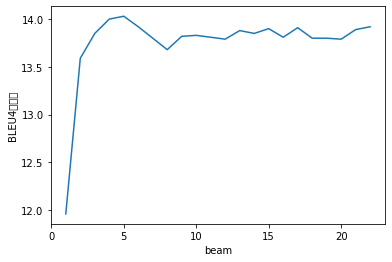

In [ ]:
import matplotlib.pyplot as plt
plt.plot(beam_num, BLEU4_score)
plt.xlabel("beam")
plt.ylabel("BLEU4スコア")
plt.show()

低くない？

## 99. 翻訳サーバの構築
ユーザが翻訳したい文を入力すると，その翻訳結果がウェブブラウザ上で表示されるデモシステムを構築せよ．

In [ ]:
!fairseq-preprocess -s en -t ja \
   --trainpref /content/drive/MyDrive/NLP100Knock/98subword/train \
   --validpref /content/drive/MyDrive/NLP100Knock/98subword/dev \
   --destdir /content/drive/MyDrive/NLP100Knock/98JESC_sub_en_ja \
   --workers 20
# pref で参照元を指定
# destdir で保存先を指定
# threshold で閾値以下の単語をunkにマップ
# task defalut translation

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/98JESC_sub_en_ja \
  --task translation \
  --arch transformer \
  --fp16 \
  --max-epoch 5 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 2000 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 8000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save98en_sub_JESC > /content/drive/MyDrive/NLP100Knock/98JESCen_sub_train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu

In [ ]:
!fairseq-preprocess -s en -t ja \
   --trainpref /content/drive/MyDrive/NLP100Knock/train.subword \
   --validpref /content/drive/MyDrive/NLP100Knock/dev.subword \
   --destdir /content/drive/MyDrive/NLP100Knock/subword_en_ja \
   --workers 20
# pref で参照元を指定
# destdir で保存先を指定
# threshold で閾値以下の単語をunkにマップ
# task defalut translation

In [ ]:
!fairseq-train /content/drive/MyDrive/NLP100Knock/subword_en_ja \
  --task translation \
  --arch transformer \
  --restore-file /content/drive/MyDrive/NLP100Knock/save98en_sub_JESC/checkpoint_5.pt \
  --fp16 \
  --max-epoch 10 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
  --optimizer adam --clip-norm 1.0 \
  --lr 1e-4 --weight-decay 0.0001\
  --dropout 0.2 \
  --max-tokens 8000 \
  --save-dir /content/drive/MyDrive/NLP100Knock/save98en_sub_KFTT > /content/drive/MyDrive/NLP100Knock/98en_sub_KFTT_train.log

# arch で使用するモデルのアーキテクチャを指定
# restore-file で事前学習済みの物をginetuneするなら

# scoring defalut bleu
# --bpe byte_bpe でバイトペアエンコーディングの使用

In [ ]:
import spacy
from fairseq.models.transformer import TransformerModel
# -*- coding: utf-8 -*-
from flask import Flask, render_template, request

nlp = spacy.load('ja_ginza')

app = Flask(__name__)

# getのときの処理
@app.route('/', methods=['GET'])
def get():
	return render_template('index.html', \
		title = '日英翻訳機', \
		message = '訳したい文を入力')

# postのときの処理	
@app.route('/', methods=['POST'])
def post():
    flag = request.form.get('radio')
    text = request.form['text']
    if flag =="ja_en":
		DICT_PATH = "/content/drive/MyDrive/NLP100Knock/subword_ja_en"
		MODEL_PATH = '/content/drive/MyDrive/NLP100Knock/save98_sub_KFTT'
		MODEL_CHECKPOINT = 'checkpoint_best.pt'
		model = TransformerModel.from_pretrained(MODEL_PATH, MODEL_CHECKPOINT, DICT_PATH)
		trans_text = text
		doc = [token.text for token in doc]
		trans_text = ' '.join(text)
		trans_text = model.translate(trans_text)
		return render_template('index.html', title = 'Form Sample(post)', message = '原文(日本語):{}訳文(英語):'.format(text,trans_text))
    elif flag == "en_ja":
		DICT_PATH = "/content/drive/MyDrive/NLP100Knock/subword_en_ja"
		MODEL_PATH = '/content/drive/MyDrive/NLP100Knock/save98en_sub_KFTT'
		MODEL_CHECKPOINT = 'checkpoint_best.pt'
		model = TransformerModel.from_pretrained(MODEL_PATH, MODEL_CHECKPOINT, DICT_PATH)
		trans_text = text
		trans_text = model.translate(trans_text)		
        return render_template('index.html', \
		    title = 'Form Sample(post)', \
		    message = '原文(英語):{}訳文(日本語):'.format(text))

app.run(port=12345)

In [ ]:
：<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Document</title>
</head>
<body>
	<h1>{{ title }}</h1>
	<p>{{ message }}</p>
	<form action="/" method="POST" enctype="multipart/form-data">
        <div>
			<label for="r1">日英翻訳：</label>
			<input type="radio" id="r1" name="radio" value="ja_en">
		</div>
		<div>
			<label for="r2">英日翻訳：</label>
			<input type="radio" id="r2" name="radio" value="en_ja">
		</div>
		<div>
			<label for="原文">原文：</label>
			<input type="text" id="name" name="text" placeholder="原文">	
		</div>
		<div>
			<input type="submit" value="送信">
		</div>
	</form>
</body>
</html>

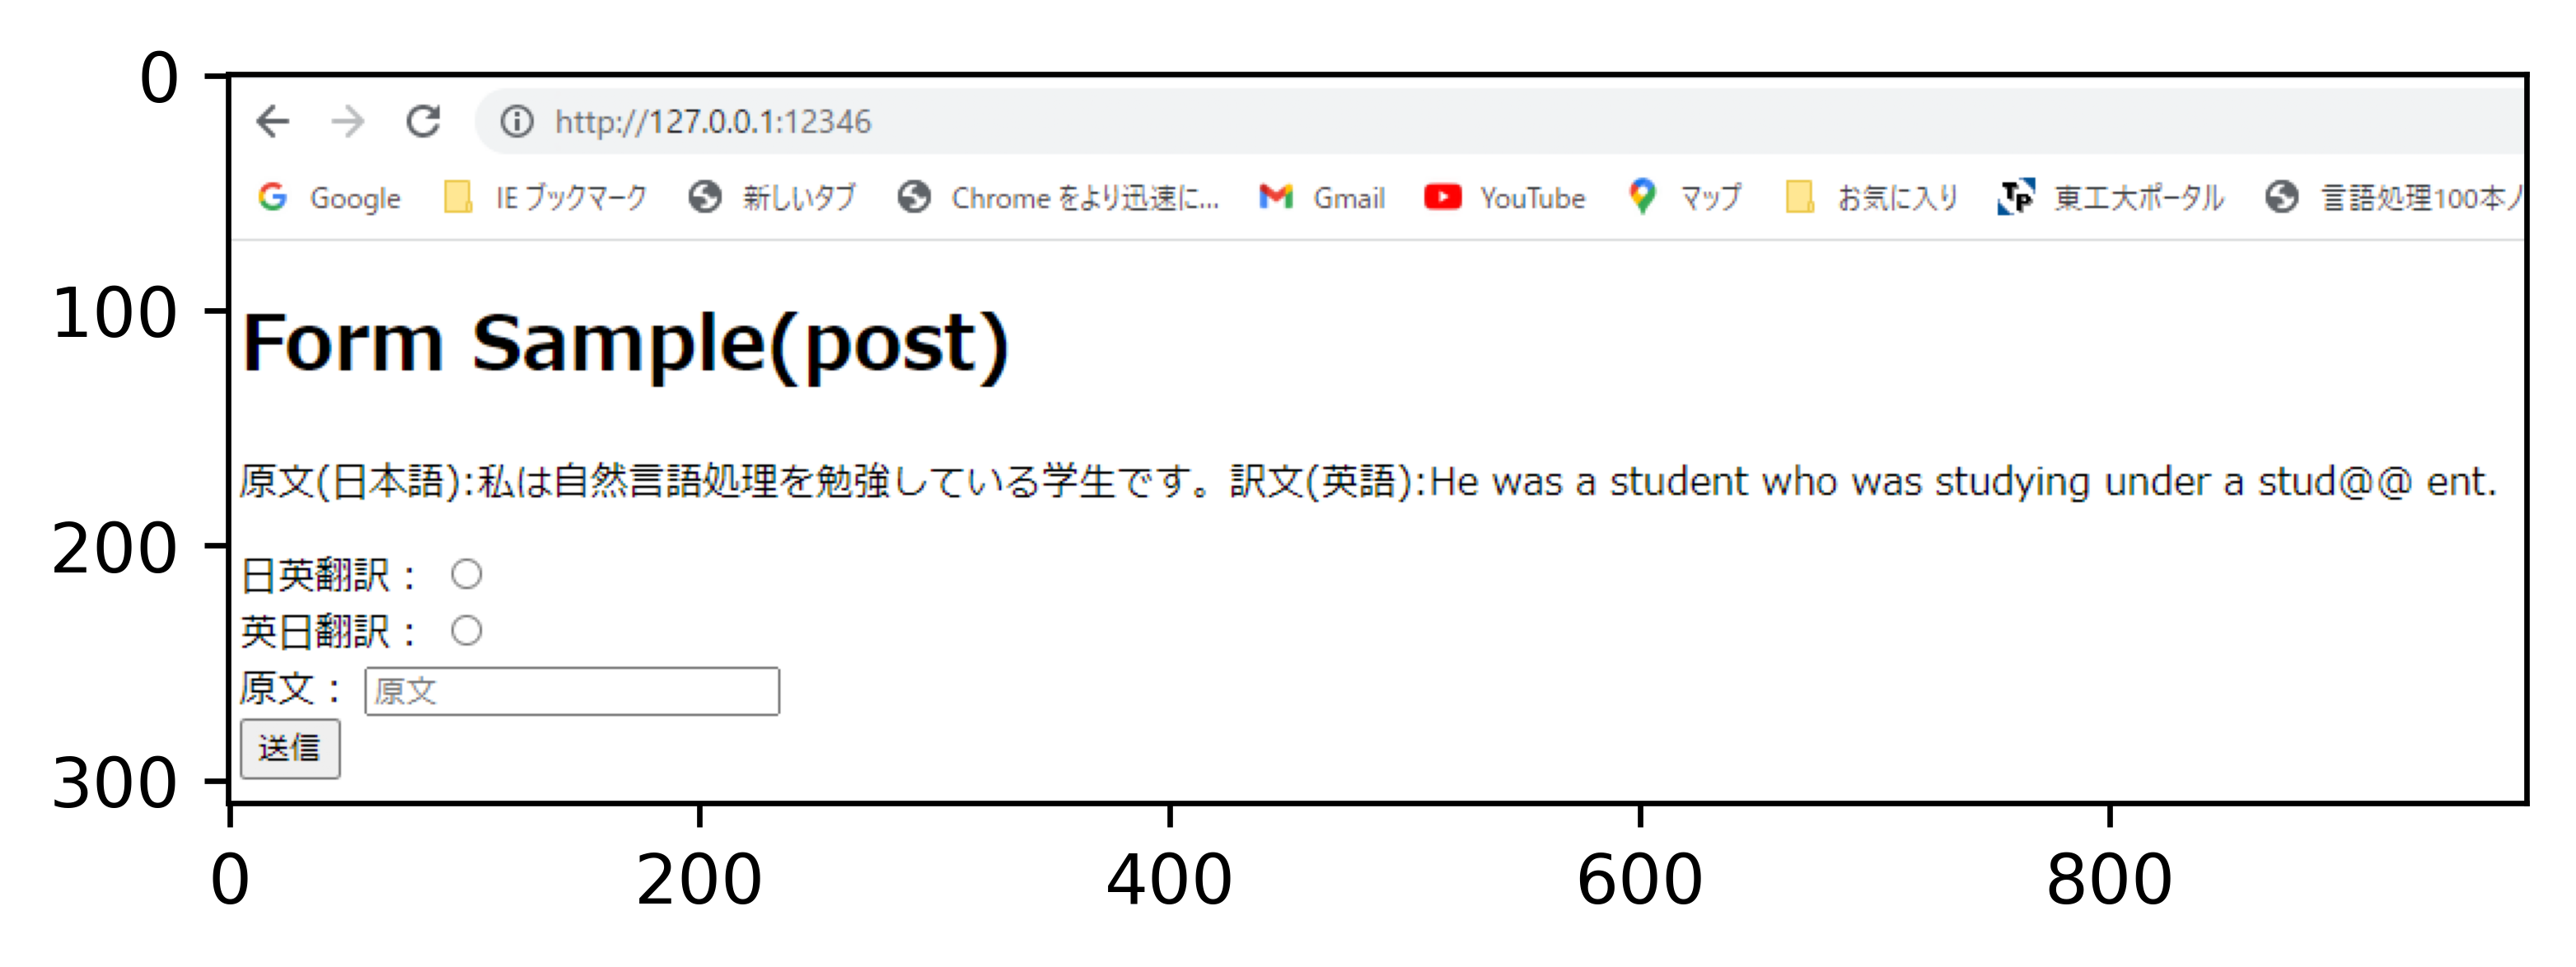

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/drive/MyDrive/NLP100Knock/ja_en.png")
fig = plt.figure(dpi=600)
imgplot = plt.imshow(img)

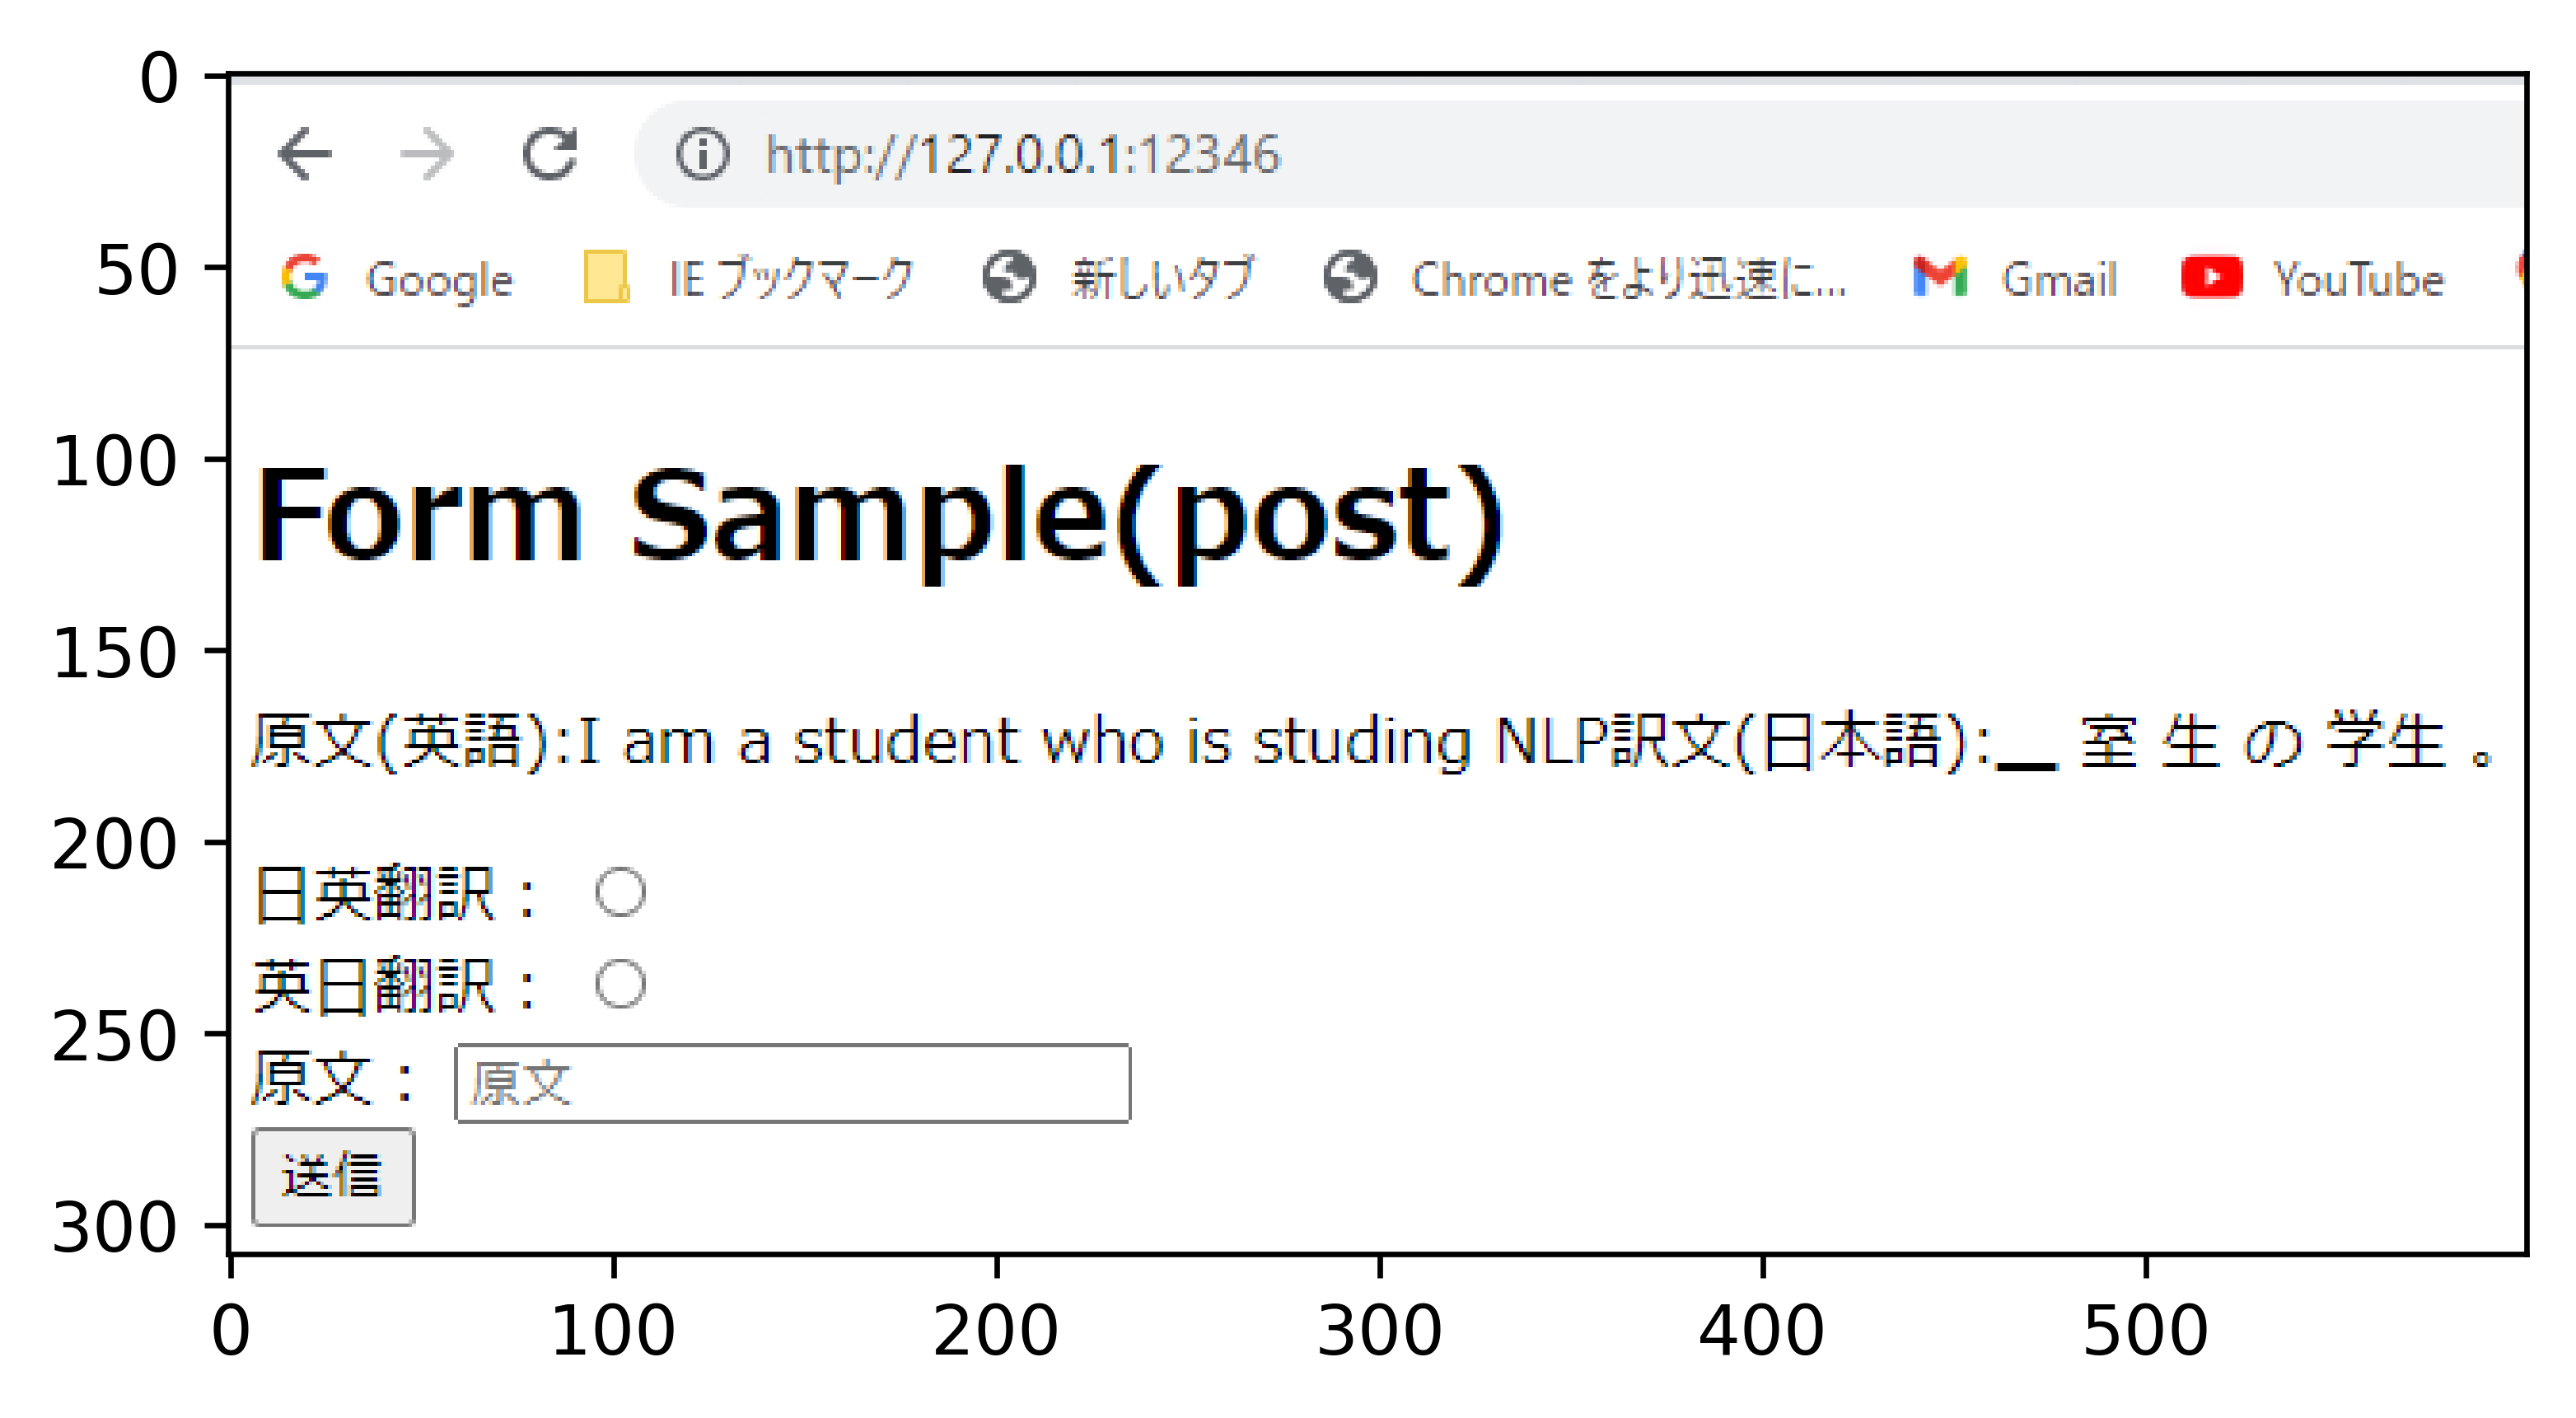

In [23]:
img = mpimg.imread("/content/drive/MyDrive/NLP100Knock/en_ja.png")
fig = plt.figure(dpi=600)
imgplot = plt.imshow(img)

精度が微妙すぎる・・・